# LSTM for Text Classification:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

C:\Users\Akshay\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Akshay\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Akshay\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Akshay\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [4]:
print(tf.__version__)

1.14.0


In [7]:
import io
df = pd.read_csv('spam.csv', delimiter=',', encoding='latin-1')

In [8]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [10]:
# Drop the columns that are not required for the neural network.
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
df.columns

Index(['v1', 'v2'], dtype='object')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


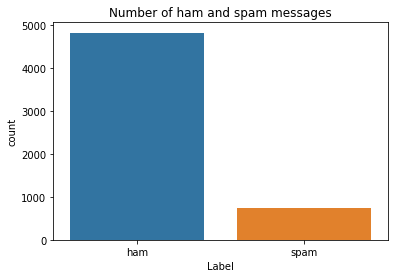

In [14]:
# Understand the distribution better.
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages');

Create input and output vectors.

Process the labels.

In [15]:
X = df.v2
X.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: v2, dtype: object

In [17]:
Y = df.v1
Y.head()

0     ham
1     ham
2    spam
3     ham
4     ham
Name: v1, dtype: object

In [18]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y

array([0, 0, 1, ..., 0, 0, 0])

In [20]:
Y.shape

(5572,)

In [24]:
Y = Y.reshape(-1,1)
Y.shape

(5572, 1)

In [25]:
Y

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [26]:
# Split into training and test data.
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [27]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4736,)
(836,)
(4736, 1)
(836, 1)


# Process the data:

Tokenize the data and convert the text to sequences.

Add padding to ensure that all the sequences have the same shape.

There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

In [28]:
# 100 Frequently Occuring words:
max_words = 1000

# Define the sequence lengths, max number of words and embedding dimensions
# Sequence length of each sentence. If more, truncate. If less, pad with zeros
max_len = 150

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
tok

In [29]:
sequences = tok.texts_to_sequences(X_train)
sequences

[[38, 501],
 [9, 66, 106, 147],
 [98, 3, 35, 2, 251, 55, 2, 53, 32, 3, 198, 33, 5, 88, 45, 33, 132, 26, 38],
 [45, 106, 64, 24, 1, 269, 30, 305, 18, 87],
 [132, 47, 168, 110, 29, 605, 306, 16],
 [159, 96, 28, 10, 43, 42],
 [1, 93, 69, 2, 375, 175],
 [18, 25, 665, 15, 3],
 [166, 92, 1, 240, 165, 165, 133, 117, 1, 191, 169, 3, 92],
 [55,
  6,
  606,
  184,
  284,
  4,
  161,
  666,
  111,
  743,
  19,
  24,
  32,
  6,
  89,
  12,
  11,
  667,
  1,
  224,
  636,
  8,
  853,
  39,
  198,
  541,
  2,
  162,
  8],
 [1, 28, 153, 208, 24, 444, 25, 4, 307, 8, 918, 15, 44, 111],
 [128, 59, 502, 270, 39, 22, 54, 66],
 [332, 33, 4, 354, 169, 175, 41, 37, 261, 177, 24],
 [194,
  100,
  16,
  47,
  4,
  355,
  518,
  152,
  26,
  4,
  41,
  262,
  519,
  431,
  173,
  287,
  503,
  376,
  335,
  263],
 [2, 3, 136, 188, 1, 68, 212],
 [82, 92, 86, 1, 377, 59, 2, 336, 1, 17, 573],
 [1, 36, 488, 195, 744, 178],
 [48],
 [919, 306, 209, 35, 200, 637, 13, 345, 7, 306, 16, 20, 920, 209, 306, 225],
 [921, 11

In [31]:
# Converting the Sequences recieved to matrix formation for ease of computation:
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
sequences_matrix

array([[  0,   0,   0, ...,   0,  38, 501],
       [  0,   0,   0, ...,  66, 106, 147],
       [  0,   0,   0, ..., 132,  26,  38],
       ...,
       [  0,   0,   0, ...,   1,  78,   3],
       [  0,   0,   0, ...,  68,   3, 188],
       [  0,   0,   0, ...,  56, 213,  30]])

**RNN**

Define the RNN structure.

In [32]:
def RNN():
    i = Input(name='inputs', shape=[max_len])
    x = Embedding(max_words, 50, input_length=max_len)(i)
    x = LSTM(64)(x)
    x = Dense(256, name='FC1', activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, name='out_layer', activation='sigmoid')(x)
    model = Model(inputs=i, outputs=x)
    return model

In [33]:
# Calling RNN function & Compiling the model:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_______________________

In [34]:
# Fiting our model over the training data:
r = model.fit(sequences_matrix, Y_train, batch_size=128, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

Train on 3788 samples, validate on 948 samples
Epoch 1/10
3788/3788 [==============================] - 14s 4ms/sample - loss: 0.3345 - acc: 0.8725 - val_loss: 0.1694 - val_acc: 0.9662
Epoch 2/10
3788/3788 [==============================] - 10s 3ms/sample - loss: 0.1007 - acc: 0.9760 - val_loss: 0.0579 - val_acc: 0.9821
Epoch 3/10
3788/3788 [==============================] - 11s 3ms/sample - loss: 0.0477 - acc: 0.9857 - val_loss: 0.0615 - val_acc: 0.9789


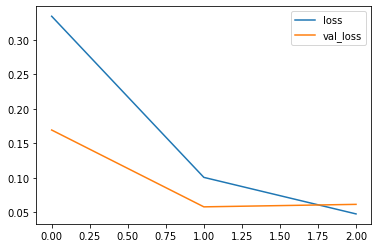

In [35]:
# Plotting Loss per Iteration:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

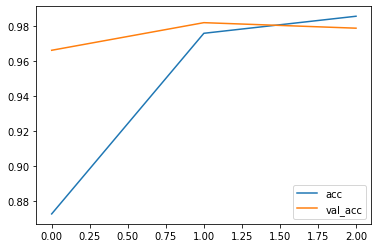

In [37]:
# Plot accuracy per iteration
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()

# The model performs well on the validation set and this configuration is chosen as the final model.


In [38]:
# process the test data set:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [39]:
# Evaluate the model on the test data:
accr = model.evaluate(test_sequences_matrix, Y_test)

836/836 [==============================] - 1s 1ms/sample - loss: 0.0315 - acc: 0.9952


In [44]:
print('Test Set \n')
print('Loss:', accr[0]*100,'%')
print('Accuracy:', accr[1]*100,'%')

Test Set 

Loss: 3.1480704376286868 %
Accuracy: 99.52152967453003 %
